In [199]:
!pip install clickhouse-driver[lz4]

# Импорт библиотек

In [200]:
import numpy as np
import pandas as pd 
from clickhouse_driver import Client
from datetime import date
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from math import sqrt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

**Функции которые потребуются для извлечения данных и дальнейшей обработки**

In [201]:
def timeseries_train_test_split(X, y, test_size):    
    
    test_index = int(len(X)*(1-test_size))    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test
def AllDataForItem(item_id):
    # Запрос на получение данных о заданном товаре на всем интервале времени со всех складов
    df = pd.DataFrame(client.execute('select sum(quantity) as Quantity, sum(amount) as Amount,date, sum(price) as Price, sum(sebes) as Sebes \
                                            from sales \
                                            where item_id = %(item_id)s \
                                            group by date \
                                            order by date',{'item_id': item_id}), columns = ['Quantity','Amount','Date','Price','Sebes'])
    return df
def feat_mod(df):
    
    df['start_day_shift1'] = df.Start_Day.shift(1)
    df['start_day_shift7'] = df.Start_Day.shift(7)
    df['start_day_shift14'] = df.Start_Day.shift(14)
    df['start_day_shift14'] = df.Start_Day.shift(28)
    df['start_day_shift14'] = df.Start_Day.shift(56)    
    df['Finish_day_shift7'] = df.Finish_day.shift(7)
    df['Finish_day_shift14'] = df.Finish_day.shift(14)
    df['Finish_day_shift28'] = df.Finish_day.shift(28)
    df['Finish_day_shift56'] = df.Finish_day.shift(56)
    #df['roll_start_day7'] = df.Start_Day.rolling(7).sum()
    #df['roll_finish_day7'] = df.Finish_day.rolling(7).sum()
    df['price_diff'] = df.Price - df.Sebes
    df = df.dropna()
    df = df.set_index('Date')
    return df
def DataForEveryWarehouse(ware_id, item_id,warehouses_nums):
  #Сбор данных для каждого склада по отдельности, присвоение UUID->number
        
    df_ware = pd.DataFrame(client.execute('select sum(quantity) as Quantity, sum(amount) as Amount,date, sum(price) as Price, sum(sebes) as Sebes \
                                            from sales \
                                            where item_id = %(item_id)s and warehouse_id = %(ware_id)s \
                                            group by date order by date',{'item_id': item_id, 'ware_id': ware_id}), columns = ['Quantity','Amount','Date','Price','Sebes'])
        
    df_stock = pd.DataFrame(client.execute('select sum(start_day) as SD, sum(finish_day) as ED, date \
                                            from stocks_on_days \
                                            where item_id = %(item_id)s and stock_id = %(ware_id)s \
                                            group by date order by date',{'item_id': item_id, 'ware_id': ware_id}), columns = ['Start','Finish','Date'])
    df_ware['ware'] = ware_id[0]
    for idx,_ in enumerate(warehouses_nums):
        if df_ware['ware'][0] == warehouses_nums[idx][0]:            
            df_ware['ware'] = (warehouses_nums[idx][1])
                
    df_stock = df_stock.set_index(['Date'])
    df_ware = df_ware.set_index(['Date'])    
    df_stock = df_stock.loc[min(df_ware.index):max(df_ware.index)]
    
    df_ware['Start_Day_Ware'] = df_stock.Start
    df_ware['Finish_Day_Ware'] = df_stock.Finish
    #df_ware = df_ware.reset_index()
    return df_ware


**Прописывать руками логин и пасс не стоит, но для выполнения тестового наверное можно. Подключаемся к ДБ**

In [202]:

host='***'
user='***'
password='qwerty'
database='test'
client = Client(host,
                user=user,
                password=password,
                database=database)

**Посмотрим на данные**

In [203]:
all_data = pd.DataFrame(client.execute('select * from sales where item_id = %(id)s',{'id': '7d185936-7a60-11eb-ba7f-4a6a34607ded'}), columns = ['date','Warehouse_id','item_id','order_number','Price','Quantity','Amount','Sebes'])
all_data.head()

,date,Warehouse_id,item_id,order_number,Price,Quantity,Amount,Sebes
0,2021-01-04,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3547355649947603906,0,1,59.99,53.5
1,2021-01-04,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,4908248033917346488,0,1,59.99,53.5
2,2021-01-04,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1134184689814738432,0,1,59.99,53.5
3,2021-01-04,bb818041-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,765388806314934293,0,1,59.99,53.5
4,2021-01-04,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,15616877688297015768,59.99,1,59.99,53.5


**Какое распределение товара по складам? Вероятно что при построении множественных моделей для каждого склада придется учитывать веса каждого склада, ведь очевидно что количество продаж не равномерно от склада к складу.**

<AxesSubplot:>

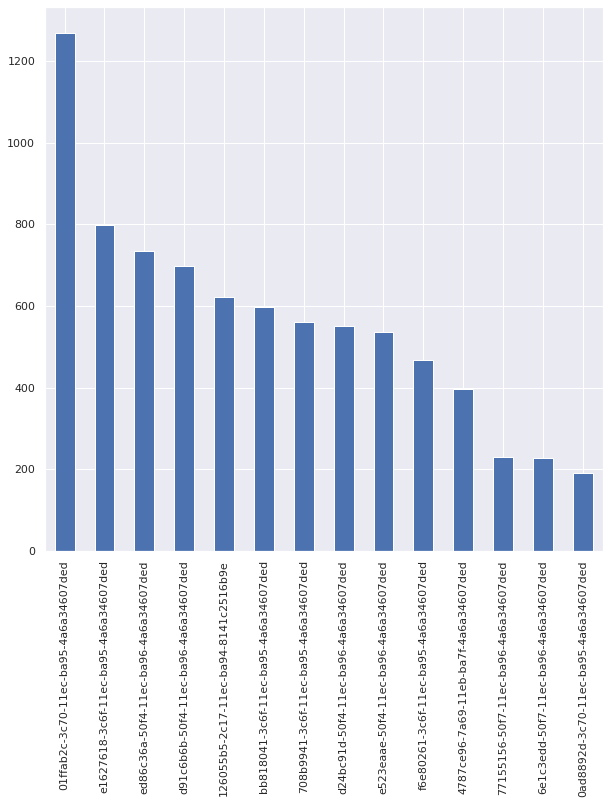

In [204]:
all_data['Warehouse_id'].value_counts().plot(kind = 'bar')

**Видно, что товар распределен неравномерно, отсюда следующее утверждение: если строить множество моделей для каждого склада, то требуется учитывать разницу в количестве продаж.**

**Выбираем уникальные значения складов для заданного товара, также выбираем их имена**

In [205]:
warehouses_ids = client.execute('select warehouse_id from sales where item_id = %(id)s',{'id': '7d185936-7a60-11eb-ba7f-4a6a34607ded'})
warehouses_ids = pd.unique(warehouses_ids)
warehouses_nums = client.execute('select * from warehouse')

**Сбор данных о заданном продукте со всех складов по дням. Была идея строить модель под каждый склад, однако из-за ошибки прогноза на каждом складе общая аддитивная ошибка будет велика, и я отказался от этой идеи. Хотя стакнуть 14 моделей и посмотреть на результат было бы интересно.**

In [207]:
item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
df = AllDataForItem(item_id)

In [208]:
df.tail()

,Quantity,Amount,Date,Price,Sebes
348,15,981.33,2021-12-26,656.5,620
349,7,455.31,2021-12-27,455.73,434
350,9,602.64,2021-12-28,484.43,434
351,11,724.39,2021-12-29,651.5,620
352,8,569.33,2021-12-30,570.22,496


**Функция проводящая исследование на стационарность. По графикам можно определить параметры модели SARIMAX, однако есть более удобный способ. Проверить характеристики ряда и посмотреть на корреляции все-таки нужно.**

In [209]:
def check_stationarity(y, lags_plots=50, figsize=(22,8)):
    
    # Рисунки
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('График продаж товара')
    plot_acf(y, lags=lags_plots, zero=False,alpha=0.05, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False,alpha=0.05, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Распределение')

    plt.tight_layout()
    
    print('Результат теста Дики-Фуллера:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nТестовая статистика ниже чем 5%, ряд стационарен')
    else:
        print("\nТестовая статистика выше чем 5%, ряд не стационарен")

In [210]:
df = AllDataForItem(item_id)
columns_to_float = ['Quantity','Amount','Price','Sebes']
df[columns_to_float] = df[columns_to_float].astype('float64')

Результат теста Дики-Фуллера:
Test Statistic                  -1.4981
p-value                          0.5344
Lags Used                        8.0000
Number of Observations Used    344.0000
Critical Value (1%)             -3.4495
Critical Value (5%)             -2.8700
Critical Value (10%)            -2.5713
dtype: float64

Тестовая статистика выше чем 5%, ряд не стационарен


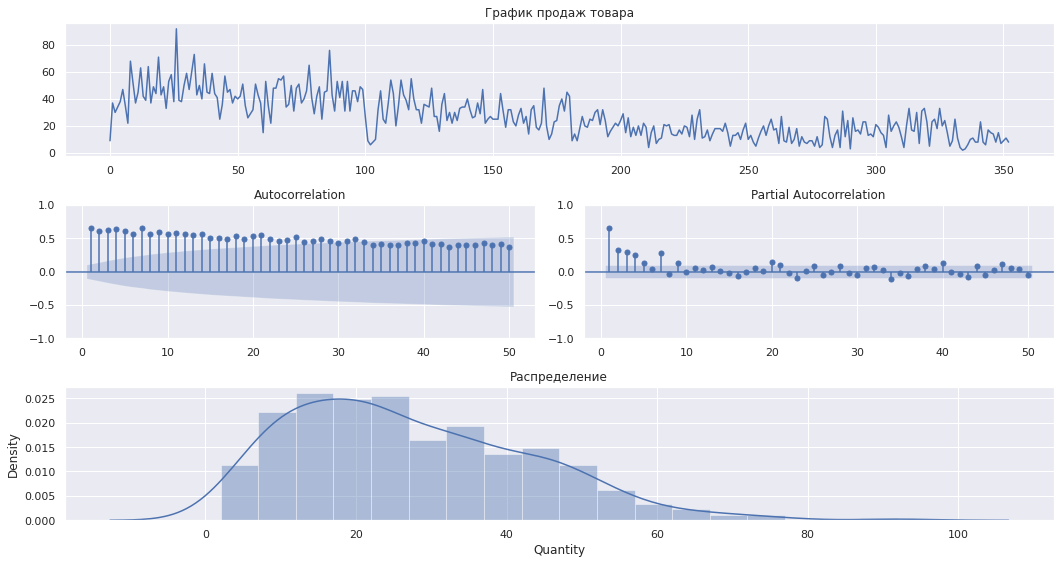

In [211]:
check_stationarity(df['Quantity'])

Результат теста Дики-Фуллера:
Test Statistic                 -10.9321
p-value                          0.0000
Lags Used                        7.0000
Number of Observations Used    344.0000
Critical Value (1%)             -3.4495
Critical Value (5%)             -2.8700
Critical Value (10%)            -2.5713
dtype: float64

Тестовая статистика ниже чем 5%, ряд стационарен


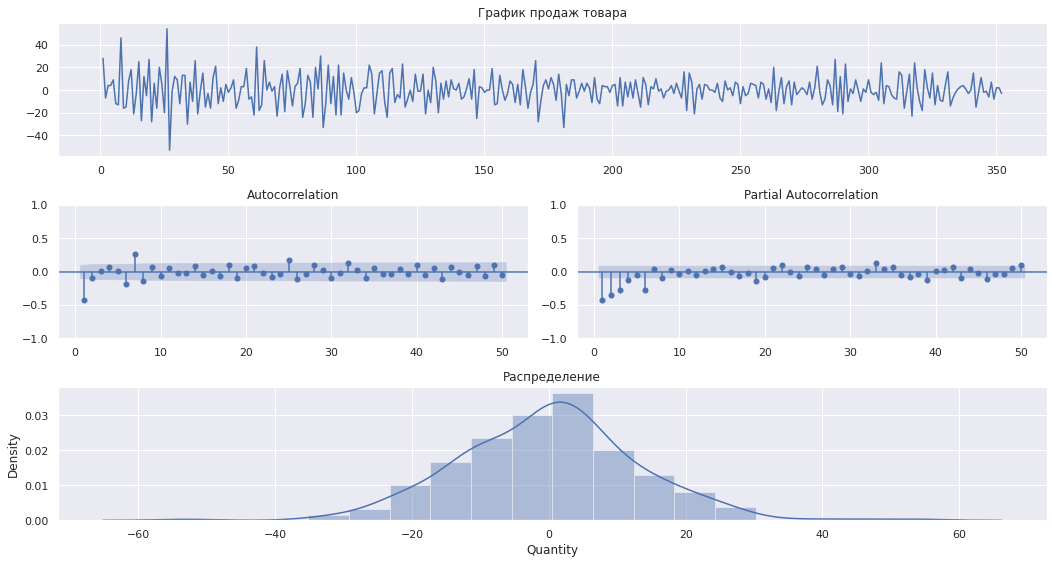

In [212]:
check_stationarity(df['Quantity'].diff().dropna())

**Как и следовало ожидать, первоначально такие ряды практически не бывают стационарными. После формирования временного лага в 1 отсчет, ряд становится стационарным. Далее требуется создать тестовую и обучающую выборку для будущей модели SARIMAX. Сразу становится ясно, что требуется использовать сторонние данные, возможно это увеличит точность предсказания. В данном случае это будет информация о праздниках в России.**

In [213]:
df = df.set_index(['Date'])
train_fin = pd.to_datetime('2021-12-10').date()
test_fin = pd.to_datetime('2021-12-30').date()
print(min(df.index))
print(max(df.index))
train,test = df[:train_fin],df[train_fin:test_fin]
import holidays
hol = pd.to_datetime(holidays.CountryHoliday('Russia')[min(df.index):max(df.index)])
exo = df.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.drop(['Quantity','Amount','Price','Sebes'],axis = 1,inplace = True)
exo_train,exo_test =  exo[:train_fin],exo[train_fin:test_fin]

2021-01-04 00:00:00
2021-12-30 00:00:00


 # SARIMAX

**Более надежный способ подбора параметров модели SARIMAX заключается в переборе всех возможных значений и выбора той модели, у которой критерий Акаике будет наименьшим.**

In [214]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit(disp = False)
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[10]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))
all_res = sarimax(train['Quantity'],exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 10) - AIC:2832.5
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 10) - AIC:2621.37
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 10) - AIC:2619.88
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 10) - AIC:2711.89
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 10) - AIC:2619.61
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 10) - AIC:2615.52
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 10) - AIC:2695.52
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 10) - AIC:2621.04
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 10) - AIC:2617.41
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 10) - AIC:2653.42
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 10) - AIC:2458.86
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 10) - AIC:2458.4
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 10) - AIC:2538.3
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 10) - AIC:2458.1
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 10) - AIC:2451.11
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 10) - AIC:2525.99
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 10) - AIC:2458.5
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 10) - AIC:2452.66
Tried out SARIM

In [215]:
all_res.sort(key=lambda x: x[1])
all_res[:5]
#(1, 1, 2), (1, 1, 2, 10)

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f76048b9210>,
  2448.232695276443,
  ((1, 1, 2), (1, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760480ed90>,
  2449.702778110437,
  ((1, 1, 2), (2, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760def1710>,
  2450.0652976954343,
  ((2, 1, 2), (1, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f76043c3e10>,
  2451.1054089955496,
  ((0, 1, 1), (1, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760de5b110>,
  2451.517154844384,
  ((2, 1, 2), (2, 1, 2, 10)))]

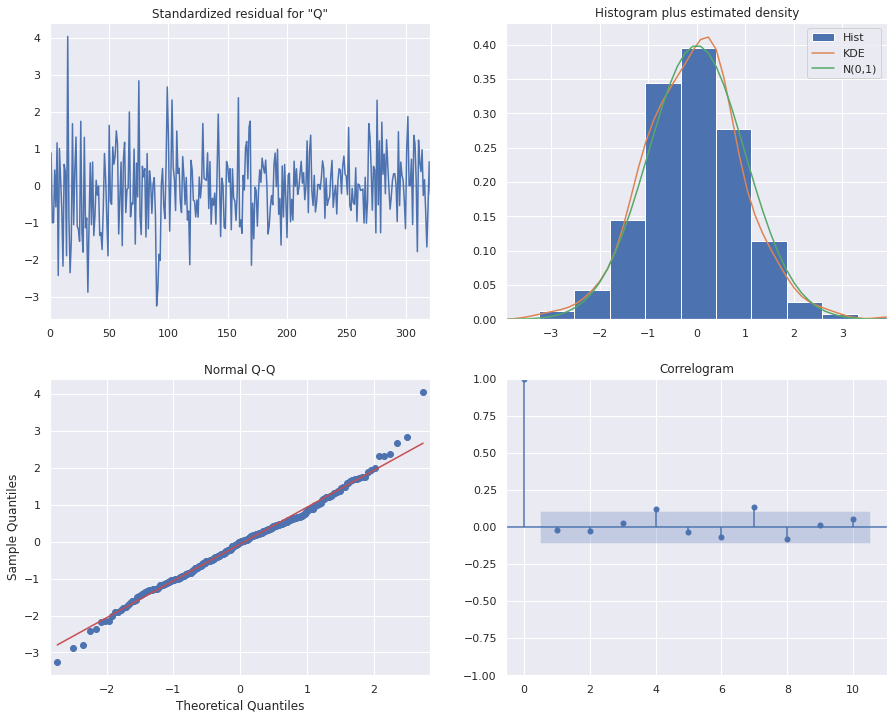

Ljung-box p-values:
[0.69985272 0.8314073  0.89936949 0.25628877 0.33869468 0.3102046
 0.07099787 0.05709848 0.08556625 0.09309528 0.13150752 0.15588086
 0.20339564 0.15742524 0.08479091 0.10014219 0.13180739 0.15845549
 0.12046675 0.15132836]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Quantity   No. Observations:                  333
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 10)   Log Likelihood               -1216.116
Date:                            Sat, 19 Feb 2022   AIC                           2448.233
Time:                                    13:32:38   BIC                           2478.429
Sample:                                         0   HQIC                          2460.288
                                            - 333                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays      -5.7879      2.840     -2.038      0.042     -11.354      -0.222
ar.L1         -0.8395      0.081    -10.363      0.000      -0.998      -0.681
ma.L1          0.0398      0.073      0.546      0.585      -0.103       0.183
ma.L2         -0.8215      0.060    -13.596      0.000      -0.940      -0.703
ar.S.L10      -0.9119      0.068    -13.467      0.000      -1.045      -0.779
ma.S.L10      -0.1682      1.472     -0.114      0.909      -3.052       2.716
ma.S.L20      -0.8283      1.252     -0.662      0.508      -3.281       1.625
sigma2        98.7339    145.011      0.681      0.496    -185.483     382.951
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                12.44
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

**Анализируя полученные графики можно сказать о нормальности и некоррелированности остатков. Более того, Q-Q график говорит о практически нормальном распределении остатков. Посмотрим как данная модель предсказывает продажи на тестовом наборе данных. В качестве метрики я взял MAE. Стоит отметить что в первый раз я проводил обучение и прогноз без выходных, и оно было лучше, примерно MAE ~= 6.59.**

In [217]:
from sklearn.metrics import mean_absolute_error as mae
forecast = res.forecast(test.shape[0],exog = exo_test)
mae_score = mae(test['Quantity'],forecast)
mae_score = 'Абсолютная ошибка составила: %.2f'% mae_score
print(mae_score)

Абсолютная ошибка составила: 8.05


**Однако с праздничными выходными данная модель показывает результат хуже, что немного удивляет. Проведем все те же операции по подготовке данных для прогноза с 30.12.21 по 06.01.22. Для этого требуется снова произвести подбор параметров модели SARIMAX.**

In [218]:
train_fin = pd.to_datetime('2021-12-30').date()
train = df[:train_fin]
hol_train = pd.to_datetime(holidays.CountryHoliday('Russia')[min(df.index):train_fin])
exo_train = df.copy()
exo_train["holidays"] = 0
exo_train.loc[hol_train] = 1
exo_train.drop(['Quantity','Amount','Price','Sebes'],axis = 1,inplace = True)
hol_val = pd.to_datetime(holidays.CountryHoliday('Russia')[max(df.index):pd.to_datetime('2022-01-08').date()])
exo_val = pd.DataFrame(data = hol_val, index = hol_val,columns = ['temp'])
exo_val['h'] = 0
exo_val.loc[hol_val] = 1
exo_val.drop('temp',axis = 1,inplace = True)

p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[10]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))
all_res = sarimax(train['Quantity'],exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 10) - AIC:2991.51
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 10) - AIC:2766.27
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 10) - AIC:2765.07
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 10) - AIC:2868.76
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 10) - AIC:2764.95
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 10) - AIC:2761.61
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 10) - AIC:2850.71
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 10) - AIC:2766.73
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 10) - AIC:2763.56
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 10) - AIC:2809.33
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 10) - AIC:2597.17
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 10) - AIC:2596.49
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 10) - AIC:2688.78
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 10) - AIC:2596.24
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 10) - AIC:2589.66
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 10) - AIC:2674.39
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 10) - AIC:2597.3
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 10) - AIC:2591.39
Tried out S

In [219]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760c7b0d90>,
  2586.300450217339,
  ((1, 1, 2), (1, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760c814a90>,
  2587.990600838232,
  ((1, 1, 2), (2, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760dbee810>,
  2588.1476052247526,
  ((2, 1, 2), (1, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f760c149990>,
  2589.66366487468,
  ((0, 1, 1), (1, 1, 2, 10))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f75feebc410>,
  2589.830574037668,
  ((2, 1, 2), (2, 1, 2, 10)))]

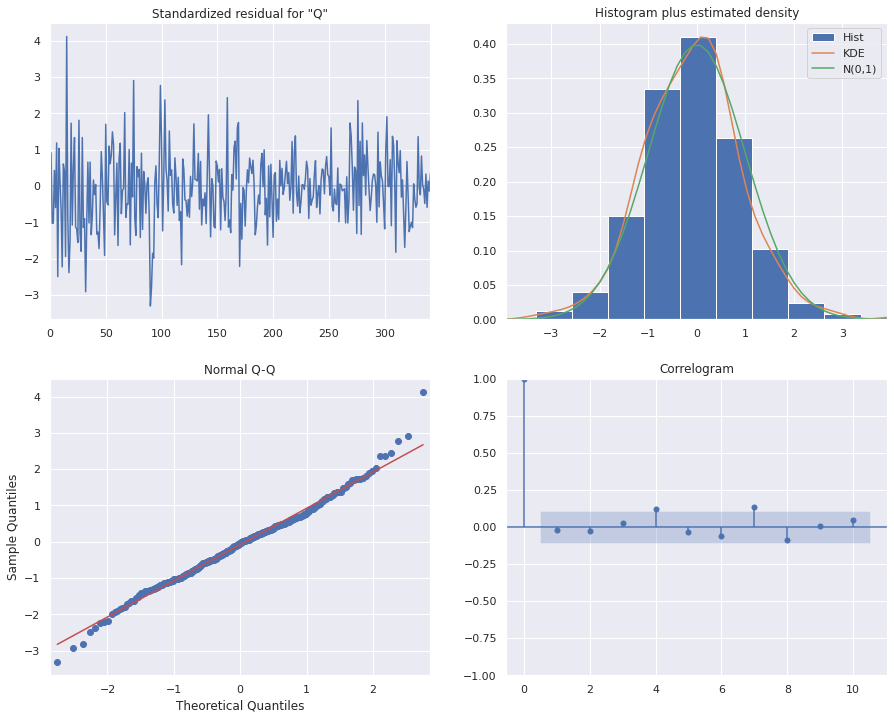

Ljung-box p-values:
[0.6905786  0.81132289 0.88879555 0.19577441 0.26300607 0.25257446
 0.04676197 0.029713   0.04772326 0.05783605 0.08148967 0.09222876
 0.12534291 0.10178115 0.04154648 0.04823539 0.06537035 0.08126743
 0.06845925 0.09079599]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Quantity   No. Observations:                  353
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 10)   Log Likelihood               -1285.150
Date:                            Sat, 19 Feb 2022   AIC                           2586.300
Time:                                    13:37:49   BIC                           2616.979
Sample:                                         0   HQIC                          2598.522
                                            - 353                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays      -5.5527      2.772     -2.003      0.045     -10.986      -0.119
ar.L1         -0.8411      0.076    -11.096      0.000      -0.990      -0.693
ma.L1          0.0494      0.068      0.724      0.469      -0.084       0.183
ma.L2         -0.8158      0.056    -14.528      0.000      -0.926      -0.706
ar.S.L10      -0.9138      0.067    -13.621      0.000      -1.045      -0.782
ma.S.L10      -0.1586      0.707     -0.224      0.823      -1.544       1.227
ma.S.L20      -0.8348      0.624     -1.338      0.181      -2.058       0.388
sigma2        95.8133     67.439      1.421      0.155     -36.365     227.992
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                15.76
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

**Параметры модели не изменились, а значит можно ожидать примерно такую же ошибку.**

In [221]:
forecast = res.forecast(steps = 7, exog = exo_val)
fcst =forecast.reset_index()
numdays = 7
base = max(df.index)
date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
sar_fcst = pd.DataFrame(data = date_list,columns = ['dates'])
sar_fcst['quantites'] = fcst['predicted_mean']
sar_fcst.to_csv('SARIMAX.csv',index = False,sep = ',')
sar_fcst.head(10)

,dates,quantites
0,2021-12-30,4.329102
1,2021-12-31,0.209955
2,2022-01-01,3.539805
3,2022-01-02,7.433844
4,2022-01-03,3.628265
5,2022-01-04,5.753900
6,2022-01-05,7.301925


#  LinReg и XGB

**Посмотрим как покажут себя модели построенные на основе линейной регрессии и градиентного бустинга. Если SARIMAX и Prophet нужны лишь отметки времени и сами значения ряда (не считая параметров сезонности и выходных), то для данных моделей нужно собрать как можно больше дополнительной информации, тем самым можно увеличить точность модели.**

In [222]:
minMax_dates_stocks = client.execute('select min(date) as minDate, max(date) as maxDate \
from test.stocks_on_days')
print(minMax_dates_stocks)

[(datetime.datetime(2020, 8, 26, 0, 0), datetime.datetime(2022, 1, 9, 0, 0))]


In [223]:
fp_dataset = pd.DataFrame(client.execute('select date, sum(stocks_on_days.start_day) as Start_day, sum(stocks_on_days.finish_day) as Finish_day \
                                        from stocks_on_days \
                                        where item_id = %(id)s \
                                        group by date \
                                        order by date', {'id': '7d185936-7a60-11eb-ba7f-4a6a34607ded'}), columns = ['Date','Start_Day','Finish_day'])

In [224]:
item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
sp_dataset = AllDataForItem(item_id)

**Join из БД почему-то не проходил тайм лимит, поэтому сделаем это в Pandas. Также преобразуем все признаки к float.**

In [225]:
df = fp_dataset.merge(sp_dataset, left_on = 'Date',right_on = 'Date')
columns_to_float = ['Quantity','Amount','Price','Sebes']
df[columns_to_float] = df[columns_to_float].astype('float64')

**Добавим несколько фичей, основанных на различных лагах и окнах.**

In [226]:
df_t = feat_mod(df)
df_t.head()

,Start_Day,Finish_day,Quantity,Amount,Price,Sebes,start_day_shift1,start_day_shift7,start_day_shift14,Finish_day_shift7,Finish_day_shift14,Finish_day_shift28,Finish_day_shift56,price_diff
Date,,,,,,,,,,,,,,
2021-03-01,18,21,32.0,1919.35,659.89,1444.5,41.0,50.0,0.0,55.0,51.0,23.0,20.0,-784.61
2021-03-02,22,64,51.0,3058.15,1439.76,2086.5,18.0,55.0,20.0,75.0,66.0,44.0,45.0,-646.74
2021-03-03,62,58,43.0,2578.75,719.88,1658.5,22.0,75.0,45.0,51.0,87.0,39.0,23.0,-938.62
2021-03-04,58,29,37.0,2218.21,719.88,1819.0,62.0,51.0,23.0,76.0,90.0,52.0,47.0,-1099.12
2021-03-05,29,15,15.0,899.67,359.94,695.5,58.0,76.0,47.0,65.0,81.0,73.0,20.0,-335.56


<AxesSubplot:>

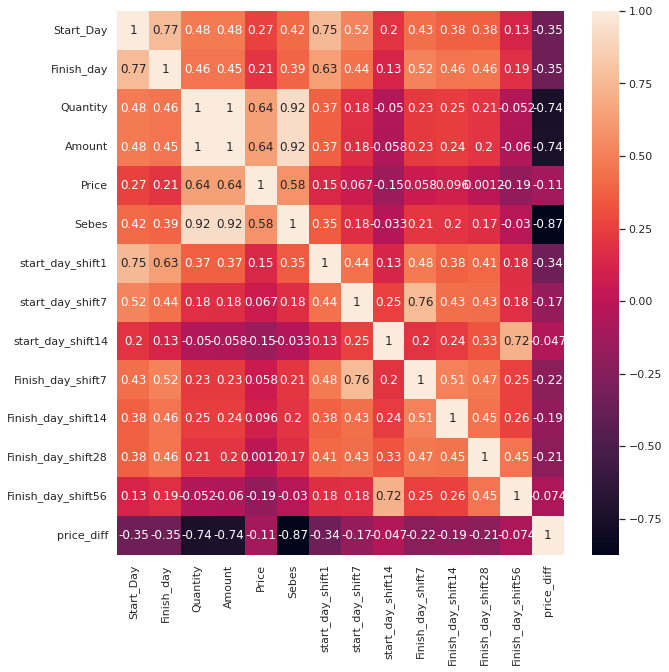

In [227]:
corr_coeffs = df_t.corr(method = 'pearson')
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(corr_coeffs,annot=True)

**Уберем все признаки, сильно коррелирующие с целевым Quantity. Таких несколько, Amount и Sebes. Признаки на основе суммы за n дней не дали значимого прироста в точности модели.**

In [228]:
df_t = df_t.drop(['Sebes','Amount'], axis = 1)

**Классический сплит на test и train, с поправкой на время. Для нормализации данных выбрал StandardScaler, по сравнению с RobustScaler никакого прироста точности не заметил.**

In [229]:
y = df_t['Quantity']
X = df_t.drop(['Quantity'], axis = 1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Начнем с обычной линейной регрессии, L1 и L2 регуляризации не сильно улучшили точность, поэтому решил оставить обычную регрессию.**

In [230]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
prediction1 = lr.predict(X_test_scaled)
error_linear = mae(prediction1, y_test)

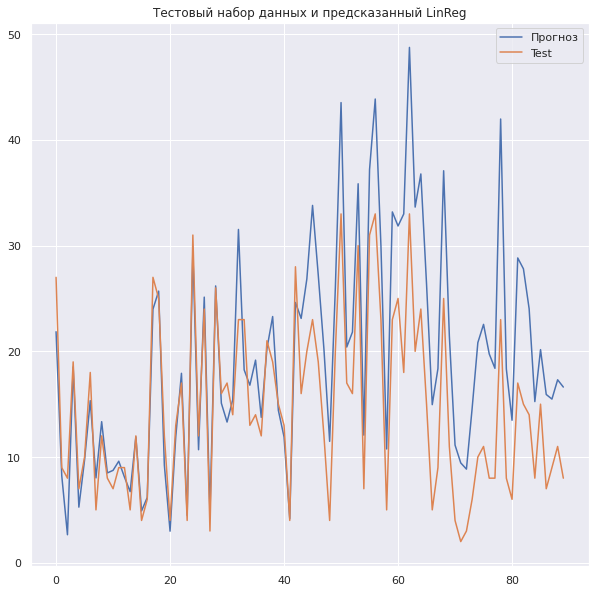

'Ошибка MAE с использованием LinReg составила = 5.709455331139263'

In [231]:
plt.plot(prediction1, label = 'Прогноз')
plt.plot(y_test.values, label = 'Test')
plt.title('Тестовый набор данных и предсказанный LinReg')
plt.legend()
plt.show()
"Ошибка MAE с использованием LinReg составила = {}".format(error_linear)

**Попробуем XGB. Интуитивно понятно что данная модель покажет лучшие результаты. Однако насколько лучше? Выборка маленькая, и разницы между LGBM и XGB по времени работы не должна быть ощутимой. Оценим точность без подбора параметров.**

In [233]:
model = xgb.XGBRegressor(n_jobs=-1,objective='reg:squarederror')   
model.fit(X_train_scaled, y_train)
prediction4 = model.predict(X_test_scaled)
error_xgb = mae(prediction4, y_test)

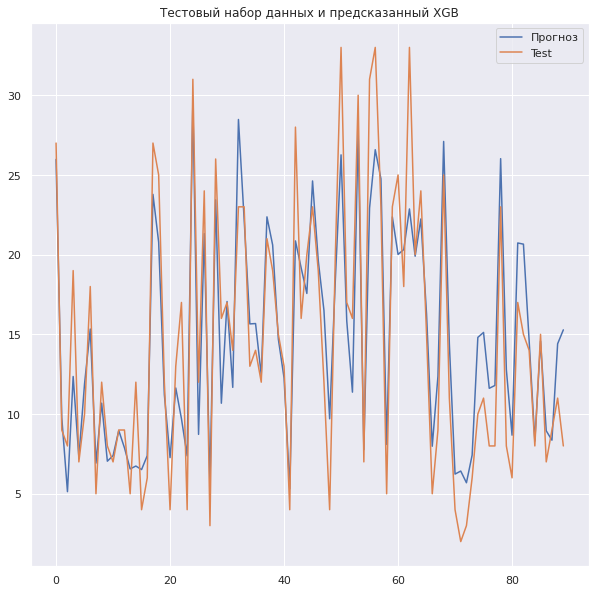

'Ошибка MAE с использованием XGB составила = 2.768021006054348'

In [234]:
plt.plot(prediction4, label = 'Прогноз')
plt.plot(y_test.values, label = 'Test')
plt.title('Тестовый набор данных и предсказанный XGB')
plt.legend()
plt.show()
"Ошибка MAE с использованием XGB составила = {}".format(error_xgb)

Text(0.5, 1.0, 'Feature Importance')

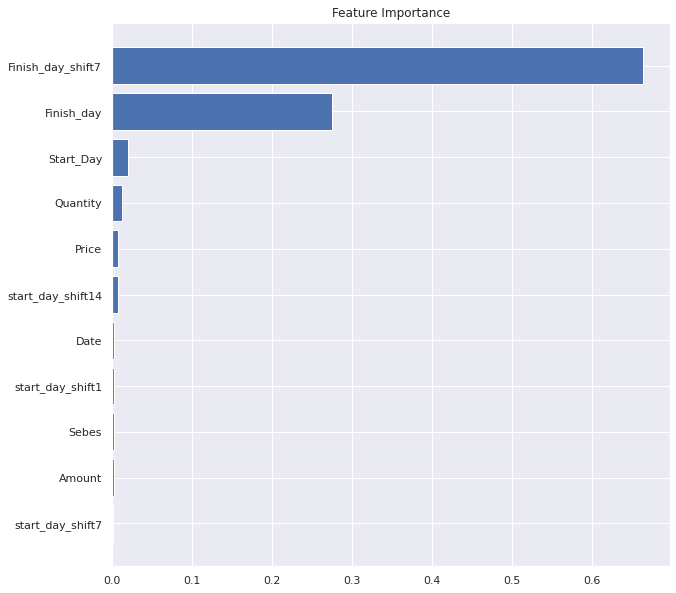

In [235]:
sorted_imp = model.feature_importances_.argsort()
plt.barh(df.columns[sorted_imp], model.feature_importances_[sorted_imp])
plt.title('Feature Importance')

**Очевидно что XGB даже без подбора параметров показывает лучшую точность по сравнению с линейной регрессией и SARIMAX. Однако для формирования прогноза на следующую неделю требуется сформировать набор данных.**